# Predicting the Suicide Rate from Aggregated Health, Behavioral, and Environmental Data

The data needs to be downloaded using the ipython notebook download_data.ipynb. One file per state containing health, behavioral, and environmental dataper year is downloaded from www.countyhealthrankings.org to the folder "downloads". The script also downloads the suicide rate from www.cdc.gov.

The first dataset is available for all years starting from 2010 with exceptions per state. The data recorded changes fro year-to-year as well as the data-structure in the files. The suicide rates are available only for years 2005, 2014, 2015, and 2016.

This ipython notebook loads the data per state and county, builds a linear regression model using a fraction of the state data, predicts the suicide rate for the remainder of the data, and predicts the suicide rate per county.

Francois Aubin <francois.y.aubin@gmail.com>

Optimized for Python 3.6 on Ubuntu 18.04

Last update in July 2018

## Loading the Data

### Some Functions

In [133]:
%matplotlib inline
import os
import copy
import pandas as pd
import pylab as pl
import seaborn
import pickle


def convert_st_to_state(st):
    """
    Returns the state name (string) from the state abreviation (string)
    """
    f = open('us_state_abbrev.pkl', 'rb')
    us_state_abbrev = pickle.load(f)
    f.close()
    if st not in us_state_abbrev.keys():
        error_text = 'No state matches {0:s}'.format(st)
        raise ValueError(error_text)
    return us_state_abbrev[st]


def select_health_files_to_load(years_to_analyze, path='downloads'):
    """
    Returns a list of files from path that have one of the years (int) in the
    supplied list
    """
    all_files = os.listdir(path)
    files = []
    for file_ in all_files:
        for year in years_to_analyze:
            if '{0:d}.xls'.format(year) in file_:
                files.append(file_)
    return sorted(files)


def load_data(files, state_or_county, path='downloads/'):
    """
    load all the databases in file anc combines them. Only keeps the state of
    the county data. Return a pandas.DataFrame.
    """
    for n_file, file_ in enumerate(files):
        # loading a database
        # print('Loading {0:s}'.format(file_))
        xls = os.path.join(path, file_)
        print(xls)
        new_df = pd.read_excel(xls, 'Ranked Measure Data', header=1)

        # droping empty lines
        # new_df = new_df.dropna(how='all')  # leaves the last empty line...
        new_df = new_df.drop(pl.where(pd.isnull(new_df["FIPS"].values))[0])

        # adding the year to the data
        year = int(xls.split('_')[1].split('.')[0])
        new_df['Year'] = pd.Series(year*pl.ones(len(new_df.index)),
                                   index=new_df.index)

        # appends the data to the main database
        if n_file == 0:
            df = copy.deepcopy(new_df)
        else:
            df = df.append(new_df, sort=True)
    # reset index
    df = df.reset_index(drop=True)

    if state_or_county == 'county':
        df = df.drop(pl.where(pd.isnull(df["County"]).values)[0])
        print("Dropping District of Columbia because it is its own county")
        df = df.reset_index(drop=True)
        df = df.drop(pl.where(df["State"].values == 'District of Columbia')[0])
    elif state_or_county == 'state':
        df = df.drop(pl.where(~pd.isnull(df["County"]).values)[0])
    else:
        error_text = 'Only "state" or "county supported. You nentered '
        error_text += '{0:s}'.format(state_or_county)

    # reset index
    df = df.reset_index(drop=True)
    return df


def exclude_redundant_data(df):
    """
    Only keeps some data columns since most are redundant with each other.
    """
    f = open('keys_to_keep.pkl', 'rb')
    keys_to_analyze = pickle.load(f)
    f.close()
    df = df.reset_index(drop=True)
    return df[keys_to_analyze]


def add_suicide_data(df, path='downloads'):
    """
    Load the suicide database and add a column to the data
    """
    # adding empty data
    df['Suicide'] = pd.Series(pl.nan*pl.ones(len(df.index)), index=df.index)

    # years to load
    years = set(df['Year'].values.astype(int))
    for year in years:
        file_name = 'SUICIDE{0:d}.csv'.format(year)

        if file_name not in os.listdir(path):
            print("Warning: no suicide data for {0:d}".format(year))
        else:
            # loading data
            suicide_df = pd.read_csv(os.path.join(path, file_name))

            # add the data state by state
            for st in suicide_df["STATE"]:
                state = convert_st_to_state(st)

                index_suicide = pl.where(suicide_df["STATE"].values == st)[0]
                if len(index_suicide) == 1:
                    # index in df
                    valid = df['State'].values == state
                    valid &= df['Year'].values == year
                    index_df = pl.where(valid)[0]
                    if len(index_df) == 1:
                        df.at[index_df[0], 'Suicide'] = suicide_df['RATE'][index_suicide[0]]
                    else:
                        warn_text = 'Warning: I expect 1 value, got '
                        warn_text += '{0:d} '.format(len(index_df))
                        warn_text += 'value in health database for '
                        warn_text += 'state {0:s}'.format(state)
                        print(warn_text)
                else:
                    warn_text = 'Warning: I expect 1 value, got '
                    warn_text += '{0:d} '.format(len(index_suicide))
                    warn_text += 'value in suicide database for '
                    warn_text += 'state {0:s}'.format(state)
                    print(warn_text)
    return df


def clean_data(df):
    """
    remove columns fron dataframe which are undefined, then remove rows with
    missing elements
    """
    # remove empty columns
    df = df.dropna(axis=1, how='all')
    # remove rows with at least 1 element missing
    df = df.dropna(axis=0, how='any')
    # reset index
    df = df.reset_index(drop=True)
    return df


def visualize_data(df, show_plots=True):
    """
    Correlation plot between all columns
    """
    pl.figure(1, figsize=(12, 9))
    pl.axes([0.25, 0.3, 0.95-0.25, 0.95-0.3])
    seaborn.heatmap(df.corr(), vmin=-1., vmax=1.)
    pl.yticks(rotation=0, fontsize=12)
    pl.xticks(rotation=90, fontsize=12)
    pl.title("Correlation between the data", fontsize=24)
    return

### Parameters

In [134]:
years_to_analyze = range(2015, 2017)
years_to_predict = [2016]  # must be included in years_to_analyze

### The Script

downloads/Alabama_2015.xls
downloads/Alabama_2016.xls
downloads/Alaska_2015.xls
downloads/Alaska_2016.xls
downloads/Arizona_2015.xls
downloads/Arizona_2016.xls
downloads/Arkansas_2015.xls
downloads/Arkansas_2016.xls
downloads/California_2015.xls
downloads/California_2016.xls
downloads/Colorado_2015.xls
downloads/Colorado_2016.xls
downloads/Connecticut_2015.xls
downloads/Connecticut_2016.xls
downloads/Delaware_2015.xls
downloads/Delaware_2016.xls
downloads/District of Columbia_2015.xls
downloads/District of Columbia_2016.xls
downloads/Florida_2015.xls
downloads/Florida_2016.xls
downloads/Georgia_2015.xls
downloads/Georgia_2016.xls
downloads/Hawaii_2015.xls
downloads/Hawaii_2016.xls
downloads/Idaho_2015.xls
downloads/Idaho_2016.xls
downloads/Illinois_2015.xls
downloads/Illinois_2016.xls
downloads/Indiana_2015.xls
downloads/Indiana_2016.xls
downloads/Iowa_2015.xls
downloads/Iowa_2016.xls
downloads/Kansas_2015.xls
downloads/Kansas_2016.xls
downloads/Kentucky_2015.xls
downloads/Kentucky_201

,Year,FIPS,State,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW,% Smokers,% Obese,...,Income Ratio,% Single-Parent Households,Association Rate,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone,Suicide
0,2015.0,1000.0,Alabama,9507.90,20.5,4.3,4.3,10.296385,21.9,33.226780,...,5.207702,38.258636,12.505125,417.968873,75.198980,12.80,15.193281,84.953408,32.3,14.9
1,2016.0,1000.0,Alabama,9544.70,21.9,4.6,4.7,10.225973,21.1,33.591186,...,5.230255,38.385412,12.512097,417.968873,74.249383,12.80,15.386311,85.306977,32.6,15.7
2,2015.0,4000.0,Arizona,6714.29,15.6,3.5,3.4,7.056993,16.6,23.897523,...,4.573525,35.817299,5.665887,416.203102,72.830135,10.12,20.126567,76.213824,34.6,18.2
3,2016.0,4000.0,Arizona,6752.50,18.7,3.9,3.7,7.025532,16.5,23.512182,...,4.630594,36.210047,5.636354,416.203102,73.882119,10.12,20.150944,76.367315,34.6,17.7
4,2015.0,5000.0,Arkansas,9067.86,19.4,4.1,3.9,9.007653,22.4,32.889819,...,4.819781,36.463520,11.908593,484.464333,77.478185,11.76,14.814716,82.199485,25.7,19.1


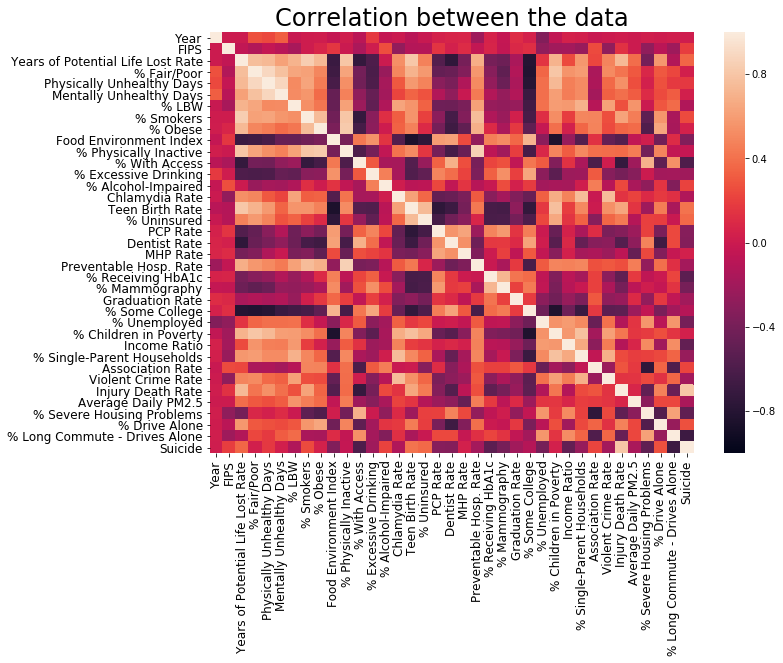

In [135]:
# selects the main databases
files = select_health_files_to_load(years_to_analyze)

# load raw database
data = load_data(files, 'state')
data_county = load_data(files, 'county')

# select columns
data = exclude_redundant_data(data)
data_county = exclude_redundant_data(data_county)

# add a column for suicide rate
data = add_suicide_data(data)

# remove columns and rows with important data missing
data = clean_data(data)
data_county = clean_data(data_county)

# show the raw data
visualize_data(data)
data.head()

## Building and Testing the Model

### Some Functions

In [136]:
import statsmodels.api as sm

def split_data(df, pred_years):
    """
    Splits df into two dataframes: the testing data for all years in
    pred_years (list), and the rest for training
    """
    # indexes of all rows for the years in pred_years
    test_index = pl.array([])
    for year in pred_years:
        index = pl.where(df['Year'].values == year)[0]
        test_index = pl.append(test_index, index)

    # splitting the data
    test_df = df.iloc[index]
    train_df = copy.deepcopy(df).drop(index)
    return train_df, test_df


def remove_keys(df):
    """
    Remove the non-numerical columns
    """
    for key_ in ['Year', 'FIPS', 'State', 'County']:
        if key_ in df.keys():
            df = df.drop([key_], axis=1)
    return df


def normalize_data(df, means=None, stds=None):
    """
    X -> (X - Xbar) / Xstd
    if means or stds not provided, they are calculated and returned as dict,
    otherwize they are float
    """
    string_keys = ['Year', 'FIPS', 'State', 'County']
    keys = [key_ for key_ in df.keys() if key_ not in string_keys]
    if means is None or stds is None:
        means = {}
        stds = {}
        for key_ in keys:
            means[key_] = pl.mean(df[key_].values)
            stds[key_] = pl.std(df[key_].values)
            df[key_] = pd.Series((df[key_] - means[key_]) / stds[key_],
                                 index=df.index)
        return df, means, stds
    else:
        for key_ in keys:
            df[key_] = pd.Series((df[key_] - means[key_]) / stds[key_],
                                 index=df.index)
        return df


def denormalize(X, mean, std):
    """
    Reciprocal function of the normalization function
    """
    return X * std + mean


def combine_county_per_state(data, states_county):
    """
    Create a matrix where each row is a state and column a county (pl.nan when
    the state is out of county)
    *** this function needs to be optimized
    """
    states = sorted(set(states_county))

    # adding all the values in a matric
    data_matrix = []
    max_columns = 0
    for n_state, state in enumerate(states):
        index = pl.where(states_county == state)[0]
        data_matrix.append(data[index])
        if len(index) > max_columns:
            max_columns = len(index)

    # filling up the array so all rows have the same # of columns
    for n_state in range(len(states)):
        n_to_add = max_columns - len(data_matrix[n_state])
        data_matrix[n_state] = pl.append(data_matrix[n_state],
                                         pl.nan*pl.ones(n_to_add))
    return data_matrix

### The Script

In [137]:
# normalize the data
data, means, stds = normalize_data(data)
data_county = normalize_data(data_county, means, stds)

# split the data into training and testing data sets
train_data, test_data = split_data(data, years_to_predict)

# remove classification data, County not present for state analysis
states = train_data['State'].values
train_data = remove_keys(train_data)
test_data = remove_keys(test_data)
states_county = data_county['State'].values
county = remove_keys(data_county)


# formating the data for the model
X_train = train_data.values
Y_train = X_train[:, -1]
X_train = X_train[:, :-1]
X_test = test_data.values
Y_test = X_test[:, -1]
X_test = X_test[:, :-1]
X_county = county.values

# model - linear regression
model = sm.OLS(Y_train, X_train)
results = model.fit()
# data prediction and cross-check
predicted_train = model.predict(results.params, X_train)
predicted_test = model.predict(results.params, X_test)
predicted_county = model.predict(results.params, X_county)

# printing the results
param_names = list(train_data.keys().values)
param_names.remove('Suicide')
print('\n{0:35s}: {1:7s} {2:7s}'.format('parameter name', 'value', 'p-value'))
for i in pl.argsort(results.pvalues):
    print('{0:35s}: {1:7.4f} {2:7.4f}'.format(param_names[i],
                                              results.params[i],
                                              results.pvalues[i]))


parameter name                     : value   p-value
Association Rate                   : -0.3753  0.1303
% Long Commute - Drives Alone      : -0.4756  0.1309
Injury Death Rate                  :  0.4425  0.1496
% Uninsured                        :  0.3516  0.1755
% Children in Poverty              : -0.5390  0.2280
% Single-Parent Households         : -0.4233  0.2604
% Some College                     : -0.2777  0.2609
Chlamydia Rate                     :  0.2885  0.2810
% Alcohol-Impaired                 : -0.1239  0.2847
PCP Rate                           :  0.3414  0.2869
% Smokers                          :  0.2918  0.3748
% Mammography                      :  0.2077  0.4417
Preventable Hosp. Rate             : -0.2199  0.4446
% Severe Housing Problems          : -0.2767  0.4451
Years of Potential Life Lost Rate  :  0.3869  0.4823
MHP Rate                           : -0.1267  0.5053
Graduation Rate                    : -0.0714  0.6056
% Physically Inactive              : -0.1391 

## Vizualizing the Results

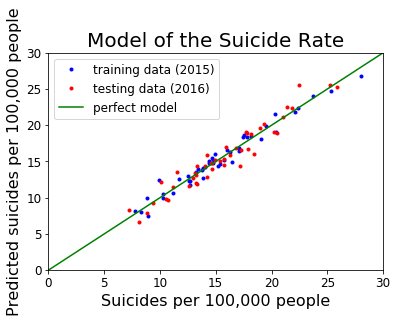

In [138]:
# de-normalizing
Y_train = denormalize(Y_train, means['Suicide'], stds['Suicide'])
predicted_train = denormalize(predicted_train, means['Suicide'],
                              stds['Suicide'])
Y_test = denormalize(Y_test, means['Suicide'], stds['Suicide'])
predicted_test = denormalize(predicted_test, means['Suicide'], stds['Suicide'])
predicted_county = denormalize(predicted_county, means['Suicide'],
                               stds['Suicide'])
f = open('model_data.pkl', 'wb')
pickle.dump({'Ytrain': Y_train, 'pred_train': predicted_train,
             'Ytest': Y_test, 'pred_test': predicted_test,
             'years_anal': years_to_analyze, 'years_pred': years_to_predict,},
             f)
f.close()

# plotting results
pl.figure(2)
# training data
label_train = 'training data ('
for year in pl.setdiff1d(years_to_analyze, years_to_predict):
    label_train += '{0:d}, '.format(year)
label_train = label_train[:-2] + ')'
pl.plot(Y_train, predicted_train, '.b', label=label_train)
# testing data
label_test = 'testing data ('
for year in years_to_predict:
    label_test += '{0:d}, '.format(year)
label_test = label_test[:-2] + ')'
pl.plot(Y_test, predicted_test, '.r', label=label_test)
# formating
max_ = 5. * pl.ceil(max([max(Y_train), max(predicted_train),
                         max(Y_test), max(predicted_test)]) / 5.)
pl.plot([0., max_], [0., max_], 'g', label='perfect model')
pl.xlim([0., max_])
pl.xlabel('Suicides per 100,000 people', fontsize=16)
pl.xticks(fontsize=12)
pl.ylim([0., max_])
pl.ylabel('Predicted suicides per 100,000 people', fontsize=16)
pl.yticks(fontsize=12)
pl.title('Model of the Suicide Rate', fontsize=20)
pl.legend(loc=2, prop={'size': 12})

f = open('data_county_map.pkl', 'wb')
pickle.dump({'data_county': data_county, 'pred_county': predicted_county}, f)
f.close()

This plot shows that the model predicts well the suicide rate using both the training dataset (unsurprising) and the testing data set. An ideal model with perfect data would predict data along the green line.

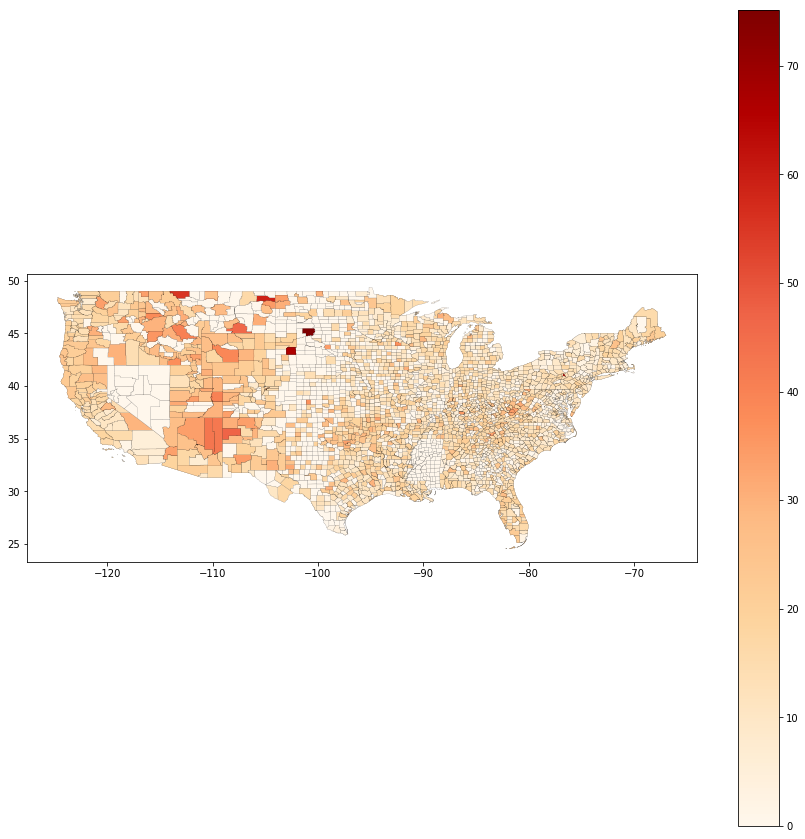

In [139]:
import json
import geopandas as gpd


# US Counties GeoJSON
geojson=open('us_counties_high_detail.json', 'r',
             encoding="ISO-8859-1").read()  # python 3
# geojson = open('us_counties_high_detail_python2.json', 'r').read()  # python 2
counties_geojson = json.loads(geojson)["features"]

# load the county definitions
df_counties = gpd.GeoDataFrame.from_features(counties_geojson)
df_counties = df_counties[df_counties.STATE != '02']  # drop Alaska
df_counties = df_counties[df_counties.STATE != '15']  # drop Hawaii
df_counties = df_counties[df_counties.STATE != '72']  # drop Puerto Rico
df_counties = df_counties.set_index(['STATE', 'COUNTY'])
df_counties = df_counties.sort_index()

# creates new dataframe for map
fips = data_county['FIPS'].values.astype(int).astype(str)
state_num = []
county_num = []
for fip in fips:
    county_num.append('{0:03d}'.format(int(fip[-3:])))
    state_num.append('{0:02d}'.format(int(fip[:-3])))
df_map = pd.DataFrame({'STATE': state_num, 'COUNTY': county_num,
                       'RATE': predicted_county},
                      columns=['STATE', 'COUNTY', 'RATE'])
# formating index
df_map = df_map.set_index(['STATE', 'COUNTY'])

# plotting map
df_counties.join(df_map).fillna(0).plot(figsize=(15, 15), column='RATE',
                                        cmap='OrRd', legend=True, vmin=0.,
                                        linewidth=0.1, edgecolor='black')
# to do: reduce size of colorbar

This plot shows the predicted suicide rate per 100,000 people per county. Missing data is shown as 0. Small counties are difficult to see.

Text(0.5,1,'Suicide Rate Prediction by County - [2016]')

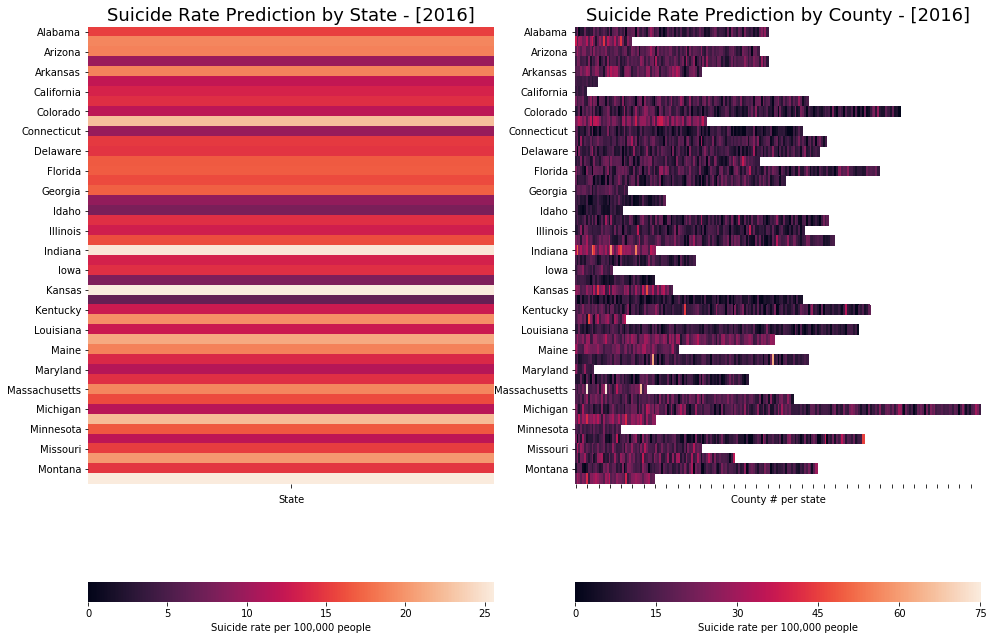

In [140]:
# plotting predictions by state
fig = pl.figure(3, figsize=(16, 12))
pl.subplot(121)
Y_to_plot = [[i] for i in predicted_test]
ax1 = seaborn.heatmap(Y_to_plot, cbar=True,
                      cbar_kws=dict(use_gridspec=False, location="bottom",
                                    label='Suicide rate per 100,000 people'),
                      vmin=0)#, vmax=max_)
pl.yticks(rotation=0)
ax1.set_yticklabels(states)
ax1.set_xticklabels([])
pl.xlabel("State")
pl.title('Suicide Rate Prediction by State - {0:s}'.format(str(years_to_predict)),
         fontsize=18)

# plotting prediction by county
pl.subplot(122)
county_to_plot = combine_county_per_state(predicted_county, states_county)
ax2 = seaborn.heatmap(county_to_plot, cbar=True,
                      cbar_kws=dict(use_gridspec=False, location="bottom",
                                    label='Suicide rate per 100,000 people'),
                      vmin=0)#, vmax=max_)
pl.yticks(rotation=0)
ax2.set_yticklabels(sorted(set(states_county)))
ax2.set_xticklabels([])
pl.xlabel("County # per state")
pl.title('Suicide Rate Prediction by County - {0:s}'.format(str(years_to_predict)),
         fontsize=18)


This plot shows the prediction per state (left panel) and per county (right panel). Counties with missing data are not shown. The states have a different number of counties. This plot awards the same visual weight to all counties as small counties are hard to see in the map.